# Real City Case

※Warning: Real data is not uploaded, so you cannot run this code. Just see how simulation goes. 

This notebook gives a brief overview on how to run simulation on real city's road network.

In [1]:
import warnings
warnings.filterwarnings('ignore')
%load_ext autoreload
%autoreload 2
import sys 
sys.path.append("../")
import osmnx as ox
import torch as th
import networkx as nx
import dgl

First load simplified road network graph G and visualize it.

In [2]:
G_simplified =ox.load_graphml('real_city_rectangular_drive_network_simplified_with_speed.graphml')

In [3]:
from speed_info import SpeedInfo
speed_info = SpeedInfo('./data/real_city_road_speed_20181023.csv')
for edge in G_simplified.edges(data=True):
    u, v, data = edge
    data['u'] = u
    data['v'] = v
    data['speed_info_closest_road_index'] = speed_info.road_names_dict[data['speed_info_closest_road']]

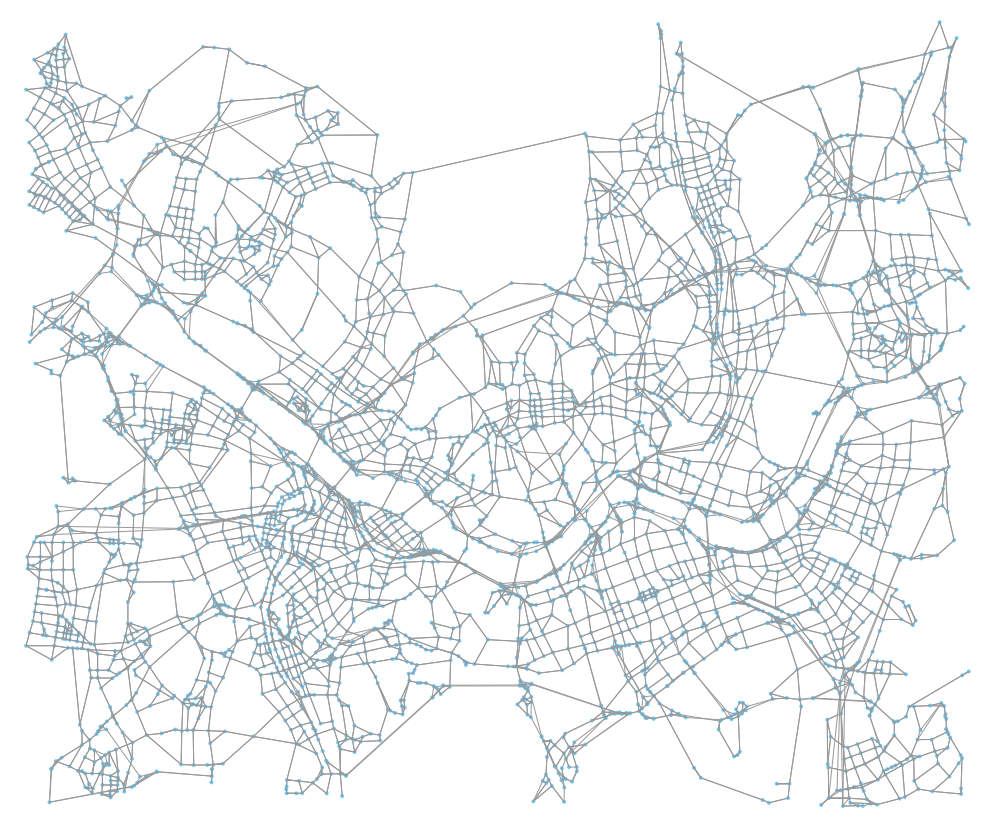

(<Figure size 1638.61x1080 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fe2d18c45c0>)

In [4]:
ox.plot_graph(G_simplified, fig_height=15)

Because above graph G is networkx Graph object, we need to convert it to dgl(deep graph library) Graph object. After conversion, let's transform the graph into its line graph.

In [5]:
g = dgl.DGLGraph()
g.from_networkx(G_simplified, edge_attrs=['length', 'u', 'v', 'speed_info_closest_road_index'])
g_line = g.line_graph(shared=True)

Now load following data.
* initial driver distribution 
* call data
* total driver number at each time

In [6]:
from driver_initializer import *
from call_generator import *

driver_initializer = BootstrapDriverInitializer('./data/real_city_idle_driver_initial_distribution_20181023.csv')
call_generator = BootstrapCallGenerator('./data/real_city_call_data_20181023.csv')
total_driver_number_per_time = TotalDriverCount('./data/real_city_total_driver_per_time_20181023.csv')

## Training
This is a code for training GCN-DQN and GAT-DQN. Rule-based strategies do not need training. First generate environment(city) and DQNAgent with different model(GAT, GCN).

In [7]:
from main import *
city = City(g_line, call_generator, driver_initializer, total_driver_number_per_time=total_driver_number_per_time, 
            speed_info = speed_info, name='real_city_with_speed', driver_coefficient=0.5, consider_speed = True, 
            verbose=True)

In [8]:
dqn_agent_gcn = DQNAgent(city, model_type='gcn', policy_pow=1.5, strategy=1)
dqn_agent_gat = DQNAgent(city, model_type='gat', policy_pow=1.5, strategy=1)

In [9]:
TRAIN_EPOCH = 5
TRAIN_TIME_STEPS = 1440
log_save_folder = 'train_logs'
model_save_folder = 'model_data'
if not os.path.exists(log_save_folder):
    os.makedirs(log_save_folder)
error_file = open('%s/error_log_gat.txt'% log_save_folder, 'w')

In [ ]:
try:
    train(city, dqn_agent_gat, epochs = TRAIN_EPOCH, time_steps=TRAIN_TIME_STEPS, write_log=True, save_model=True, log_save_folder=log_save_folder, model_save_folder=model_save_folder)
    train(city, dqn_agent_gcn, epochs = TRAIN_EPOCH, time_steps=TRAIN_TIME_STEPS, write_log=True, save_model=True, log_save_folder=log_save_folder, model_save_folder=model_save_folder)
except Exception as e:
    error_file.write(str(e))
    error_file.flush()

## Evaluation
This is a code for evaluation of different models.

In [10]:
TEST_EPOCH = 2
TEST_TIME_STEPS = 1440
save_folder = 'test_result'

In [11]:
import os
def test_all_for_city(city, save_folder):
    if not os.path.exists(save_folder):
        os.mkdir(save_folder)
    dqn_agent_gcn = DQNAgent(city, model_type='gcn', policy_pow=1.5, strategy=1)
    dqn_agent_gat = DQNAgent(city, model_type='gat', policy_pow=1.5, strategy=1)
    
    # (1) Random Agent
    evaluate(city, RandomAgent(), epochs = TEST_EPOCH, time_steps=TEST_TIME_STEPS, save_folder=save_folder)
    
    # (2) Proportional Agent
    evaluate(city, ProportionalAgent(city, proportional='order', policy_pow=1.5), epochs = TEST_EPOCH, time_steps=TEST_TIME_STEPS, save_folder=save_folder)
    
    
    # (3) GCN_DQN, GAT_DQN Agent
    error_file = open('%s/error_log.txt'% save_folder, 'w')   
    try:
        with torch.no_grad():
            evaluate(city, dqn_agent_gcn, epochs = TEST_EPOCH, time_steps=TEST_TIME_STEPS, load_model='model_data/dqn_gcn_1.5',save_folder=save_folder)
            evaluate(city, dqn_agent_gat, epochs = TEST_EPOCH, time_steps=TEST_TIME_STEPS, load_model='model_data/dqn_gat_1.5',save_folder=save_folder)
    except Exception as e:
        error_file.write(str(e))
        error_file.flush()

In [ ]:
# test on different driver number
driver_coefficients = [0.1, 0.25, 0.5]

for d in driver_coefficients:
    city = City(g_line, call_generator, driver_initializer, total_driver_number_per_time=total_driver_number_per_time, 
            speed_info = speed_info, name='real_city_with_speed', driver_coefficient=d, consider_speed = True)
    
    test_all_for_city(city, "real_city_with_driver_%.2f" % d)